In [1]:
import requests
from bs4 import BeautifulSoup
import pandas  as  pd
import matplotlib.pyplot as plt

In [2]:
url = "https://repositorio.lamolina.edu.pe/recent-submissions?offset="

# Realizar una petición HTTP a la URL
response = requests.get(url)

# Analizar el contenido HTML de la página usando Beautiful Soup
soup = BeautifulSoup(response.content, "html.parser")

# Crea el limite superior del for tomando en cuenta la cantidad de tesis expuestas en  la pagina
# insertar int((soup.find("p",{"class":"pagination-info"})).text[-4:]) en numtesis para extraer todas las tesis
numtesis = 60
limsup=numtesis/20+1

In [3]:
hrefs=[]
# Iterar sobre todos los valores de i desde 0 hasta 100
for i in range(0, int(limsup)):
    # Crear la URL de la página a scrappear
    url = "https://repositorio.lamolina.edu.pe/recent-submissions?offset=" + str(i*20)

    # Realizar una petición HTTP a la URL
    response = requests.get(url)

    # Analizar el contenido HTML de la página usando Beautiful Soup
    soup = BeautifulSoup(response.content, "html.parser")

    # Extraer todos los enlaces de la página
    links = soup.find_all("h4",{"class":"artifact-title"})


    # Iterar sobre todos los enlaces extraídos y mostrarlos por pantalla
    for link in links:
        hrefs.append("https://repositorio.lamolina.edu.pe"+link.find("a").get("href")+"?show=full")

In [4]:
# Se declaran las listas donde se almacenaran los datos
institucion=[]
titulo=[]
autor=[]
grado=[]
asesor=[]
resumen=[]
anio=[]
disciplina=[]
vacio=""

In [5]:
for i in range(len(hrefs)):
    response=requests.get(hrefs[i])
    
    # Analizar el contenido HTML de la página usando Beautiful Soup
    soup = BeautifulSoup(response.content, "html.parser")

    # Extraer la tabla que deseas
    table = soup.find("table", {"class": "ds-includeSet-table detailtable table table-striped table-hover"})

    # Convertir la tabla en un DataFrame de Pandas
    df = pd.read_html(str(table),index_col=0)[0]
    
    # Nos quedamos con la parte de la tabla que nos importa
    df=df[:][1]
    
    # Scrappeo de datos
    institucion.append(df.get("dc.publisher", vacio))   
    titulo.append(df.get("dc.title", vacio))
    anio.append(df.get("dc.date.issued", vacio))
    if "thesis.degree.discipline" in df:
        if type(df["thesis.degree.discipline"])==float:
            disciplina.append(vacio)
        else:
            if isinstance(df["thesis.degree.discipline"], str) :
                disciplina.append(df["thesis.degree.discipline"])
            else :
                disciplina.append(df["thesis.degree.discipline"][:].apply(lambda x: x).tolist())     
    else:
        disciplina.append(vacio)
    if "dc.type" in df:
        if type(df["dc.type"])==float:
            grado.append(vacio)
        else:
            if isinstance(df["dc.type"], str) :
                grado.append(df["dc.type"])
            else :
                grado.append(df["dc.type"][:].apply(lambda x: x).tolist())     
    else:
        grado.append(vacio)
    if "dc.contributor.author" in df:
        if type(df["dc.contributor.author"])==float:
            autor.append(vacio)
        else:
            if isinstance(df["dc.contributor.author"], str) :
                autor.append(df["dc.contributor.author"])
            else :
                autor.append(df["dc.contributor.author"][:].apply(lambda x: x).tolist())     
    else:
        autor.append(vacio)
        
    if "dc.contributor.advisor" in df:
        if type(df["dc.contributor.advisor"])==float :
            asesor.append(vacio)
        else:
            if isinstance(df["dc.contributor.advisor"], str) :
                asesor.append(df["dc.contributor.advisor"]) 
            else :
                asesor.append(df["dc.contributor.advisor"].apply(lambda x: x).tolist())
    else:
        asesor.append(vacio)
    
    if "dc.description.abstract" in df:
        if type(df["dc.description.abstract"])==float :
            resumen.append(vacio)
        else:
            if isinstance(df["dc.description.abstract"], str):
                resumen.append(df["dc.description.abstract"])
            else:
                resumen.append(df["dc.description.abstract"][0])
    else:
        resumen.append(vacio)

ImportError: html5lib not found, please install it

In [6]:
# Para solo quedarnos con el año en caso se haya ingresado la fecha completa
anio = [str(x)[:4] for x in anio]

# Para que donde se tenga una lista de asesores se coloque un string con ambos asesores con un espacio de por medio
for i, elemento in enumerate(asesor):
    if isinstance(elemento, list):
        asesor[i] = "\n".join(elemento)

# Para que donde se tenga una lista de autores se coloque un string con ambos autores con un espacio de por medio
for i, elemento in enumerate(autor):
    if isinstance(elemento, list):
        autor[i] = "\n".join(elemento)
        
# Para reemplazar los grados que salen en la web por un formato mas legible
dicgrado={'info:eu-repo/semantics/bachelorThesis':"Bachillerato",
          'info:eu-repo/semantics/doctoralThesis':"Doctorado",
          'info:eu-repo/semantics/masterThesis':"Maestria",
          'T_D_Bélgica':"Doctorado",
          'T_D_Manejo Forestal':"Doctorado",
          'T_M_Manejo Forestal':"Maestria",
          'info:eu-repo/semantics/article':"Articulo",
          'info:eu-repo/semantics/book':"Libro",
          'info:eu-repo/semantics/bookPart':"Libro",
          'info:eu-repo/semantics/conferenceObject':"Conferencia"}
for i, valor in enumerate(grado):
    if valor in dicgrado:
        grado[i] = dicgrado[valor]

In [7]:
datospreexportar = pd.DataFrame(list(zip(anio,institucion,titulo,autor,grado,asesor,resumen,disciplina)),columns =["Año","Institución","Titulo","Autor","Grado","Asesor","Resumen","Disciplina"])

In [8]:
datosexportar=datospreexportar[datospreexportar["Disciplina"].str.contains("Estadística|Informática", case=False)]

In [9]:
datosexportar.to_csv("repositorio_agraria_tesis.csv", sep=',')

In [10]:
datosexportar

,Año,Institución,Titulo,Autor,Grado,Asesor,Resumen,Disciplina


# Graficos

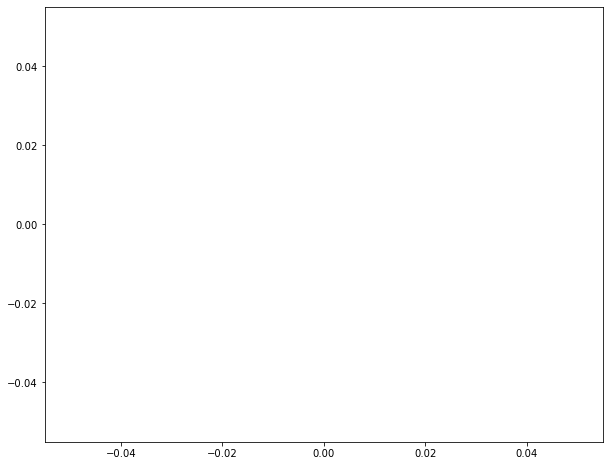

In [11]:
countanios = datosexportar['Año'].value_counts()
# Obtener las etiquetas (años) y los valores (cantidades) de la serie de conteos
etiquetas = countanios.index 
valores = countanios.values

# Crear una figura de 10x8 pulgadas
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras
plt.bar(etiquetas, valores)

# Mostrar el gráfico
plt.show()

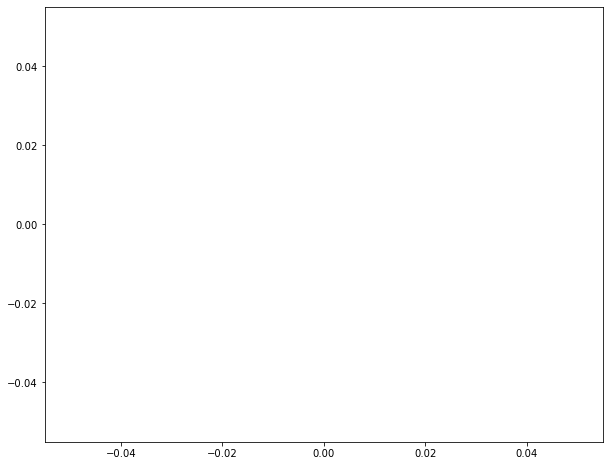

In [12]:
countgrados = datosexportar['Grado'].value_counts()
# Obtener las etiquetas (años) y los valores (cantidades) de la serie de conteos
etiquetas = countgrados.index 
valores = countgrados.values

# Crear una figura de 10x8 pulgadas
plt.figure(figsize=(10, 8))

# Crear el gráfico de barras
plt.bar(etiquetas, valores)

# Mostrar el gráfico
plt.show()